# Model 2: vgg16

## 1 Imports

In [32]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import cv2


In [34]:
dir = '../../Data/Splitted_Images/'

train_dataset = image_dataset_from_directory(
    os.path.join(dir, "train"),
    image_size=(170, 256),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(dir, "val"),
    image_size=(170, 256),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(dir, "test"),
    image_size=(170, 256),
    batch_size=32)

Found 3500 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Found 750 files belonging to 5 classes.


## 3 Training the model

In [35]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [36]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


inputs = keras.Input(shape=(170, 256, 3))
x = data_augmentation(inputs) 
x = keras.applications.vgg16.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 170, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 170, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 170, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 170, 256, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0   

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/2_VGG16_Model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor='val_loss', mode='auto', patience=5)  ]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/40
110/110 [==============================] - 30s 224ms/step - loss: 5.7142 - accuracy: 0.3286 - val_loss: 1.4802 - val_accuracy: 0.5213
Epoch 2/40
110/110 [==============================] - 22s 202ms/step - loss: 1.7262 - accuracy: 0.4291 - val_loss: 1.0274 - val_accuracy: 0.6253
Epoch 3/40
110/110 [==============================] - 22s 204ms/step - loss: 1.1944 - accuracy: 0.5560 - val_loss: 0.9477 - val_accuracy: 0.6653
Epoch 4/40
110/110 [==============================] - 23s 205ms/step - loss: 1.0005 - accuracy: 0.6334 - val_loss: 0.8153 - val_accuracy: 0.6973
Epoch 5/40
110/110 [==============================] - 22s 204ms/step - loss: 0.8773 - accuracy: 0.6774 - val_loss: 0.8507 - val_accuracy: 0.6867
Epoch 6/40
110/110 [==============================] - 23s 206ms/step - loss: 0.8059 - accuracy: 0.6934 - val_loss: 0.7674 - val_accuracy: 0.7493
Epoch 7/40
110/110 [==============================] - 22s 197ms/step - loss: 0.7061 - accuracy: 0.7414 - val_loss: 0.7372 - val_ac

## 4 Plotting the training result

In [7]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

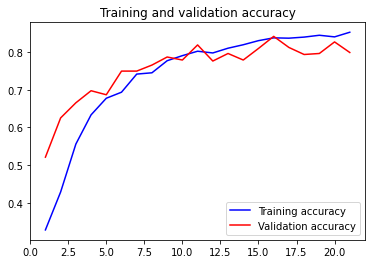

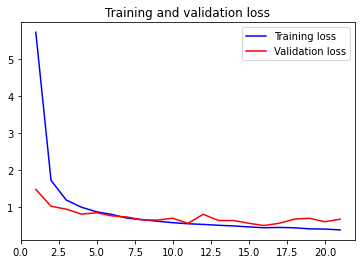

In [10]:
plot_function(history)

## 5 Testing the model on the testset

In [38]:
test_model = keras.models.load_model("models/2_VGG16_Model.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 4s 144ms/step - loss: 0.4972 - accuracy: 0.8347
Test accuracy: 0.835


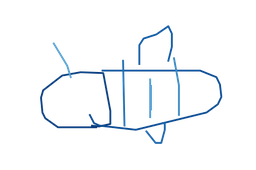

In [71]:
from PIL import Image
test_image = Image.open('../../Data/Splitted_Images/test/bee/5.png')
test_image

In [74]:
test = model.predict(test_dataset)
test.shape

(750, 5)

In [75]:
test[0]

array([2.1716314e-14, 1.1928530e-07, 6.4674900e-20, 9.9999988e-01,
       1.0011404e-09], dtype=float32)

In [79]:
for images, labels in test_dataset:
    print(images)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [94]:
# Making new Predictions
import numpy as np
from keras.preprocessing import image

test_image_luna = image.load_img('../../Data/Splitted_Images/test/bee/5.png', target_size=(170,256))
test_image2 = image.img_to_array(test_image_luna)/255.
test_image2 = np.expand_dims(test_image2, axis=0)
luna = model.predict(test_image2)
luna

array([[2.9177789e-03, 9.2846545e-05, 8.4552991e-01, 1.5079826e-01,
        6.6125975e-04]], dtype=float32)

In [121]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = test_model.predict(test_dataset) 
y_pred = (predictions >= 0.5)

matrix = metrics.confusion_matrix(test_dataset, y_pred.argmax(axis=1))
cmd = ConfusionMatrixDisplay(matrix, display_labels=['bee','butterfly','cat','dog','elephant'])
cmd.plot()

ValueError: Found input variables with inconsistent numbers of samples: [24, 750]